# ClinicalProteomic Tumor AnalysisConsortium

## Importación de Librerias

<b>Paso 0.</b> Importación de Librerias

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## ETL

<b>Paso 1.</b> Cargue de fuente de datos

In [2]:
#Import data 5.2 - Breast cancer data
dfClinical = pd.read_csv("../01. Flat Files/5.2 - Breast cancer data.csv",delimiter=",")
#dfClinical = pd.read_csv("../Datos/5.2 - Breast cancer data.csv",delimiter=",")
print("Archivo dfClinical cargado: ",dfClinical.shape)
print(dfClinical.dtypes)

Archivo dfClinical cargado:  (12553, 86)
RefSeq_accession_number     object
gene_symbol                 object
gene_name                   object
AO-A12D.01TCGA             float64
C8-A131.01TCGA             float64
                            ...   
BH-A0C7.36TCGA             float64
A2-A0SX.36TCGA             float64
263d3f-I.CPTAC             float64
blcdb9-I.CPTAC             float64
c4155b-C.CPTAC             float64
Length: 86, dtype: object


<b>Paso 2.</b> Remplazo de valores nulos por 0, dado que son necesarias para identificar corecctamente los grupos acertadamente

In [3]:
#Se identifica las columnas del DF 
arrColumnas = dfClinical.columns
for i in arrColumnas:
    #Se valida que no sean las columnas label a actualizar
    if i != "RefSeq_accession_number" and i != "gene_symbol" and i != "gene_name":
        dfClinical[i] = dfClinical[i].fillna(0)

<b>Paso 3.</b> Eliminacion de columnas label

In [4]:
#Se eliminal las columns label del DF
dfClinical = dfClinical.drop(columns=["RefSeq_accession_number","gene_symbol","gene_name"])

## Clustering

<b>Paso 4.</b> Encontrar el k optimo para la ejecución de los clusters

In [6]:
#Se importa la ejecucion secuencial 
from sklearn.pipeline import Pipeline
#Funcion para la normalizacion de variables
from sklearn.preprocessing import Normalizer
#Importacion del modelo de KMeans
from sklearn.cluster import KMeans

#Matriz para gar la distorsion del modelo de KMeans
distorsion = []
#Rango de 1 a 20 donde se probaran la diferente cantidad de clusters
K = range(1,20)

for i in K:
    #Se define el modelo de KMeans con la cantidad de clusters
    model = KMeans(n_clusters=i)
    #Se efectua el Pipeline para normalizar primero las variables y despues ejecutar el modelo de KMeans
    modeloKM = Pipeline([("normalizacion",Normalizer()),("modelo",model)])
    #Se hace la ejecucion del modelo
    modeloKM.fit(dfClinical)
    #Se guarda la inercia del modelo pora identificar la cantidad de grupos optimos
    distorsion.append(model.inertia_)

<b>Paso 5.</b> Plot de la inercia del modelo dependiendo de la cantidad de clusters

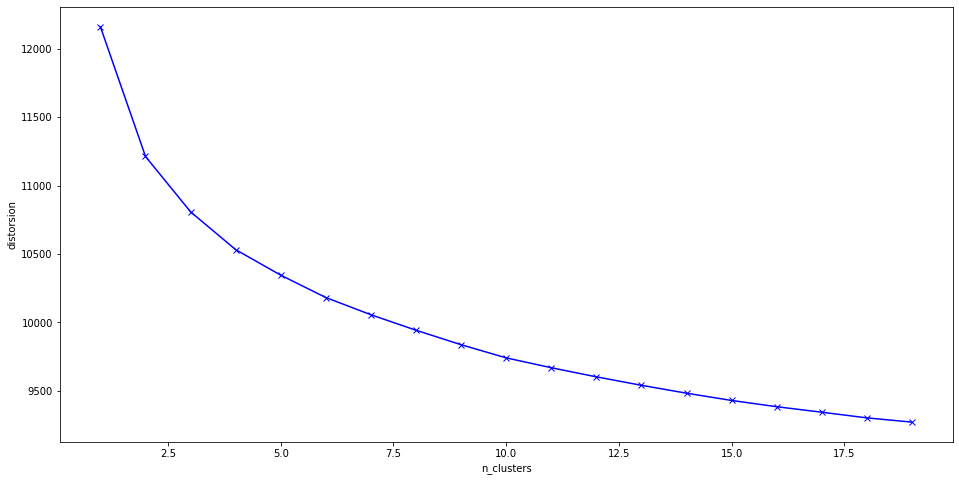

In [7]:
#Se cambia el tamaño del plot
plt.figure(figsize=(16,8))
#Se pasan los parametros del plot en el eje X la cantidad de clusters y en el Y la distorsion
plt.plot(K,distorsion,'bx-')
#Se cambia el label del eje X
plt.xlabel('n_clusters')
#Se cambia el label del eje Y
plt.ylabel('distorsion')
#Se muestra el grafico
plt.show()

Para el desarrollo de este ejercicio se tomaran 6 clusters, dado que segun la grafica canun que no es el punto de inflexion es un punto donde la distorsion del modelo se empieza a reducir mucho menos en cada paso

<b>Paso 6.</b> Ejecucion del modelo KMeans con 6 clusters

In [8]:
#Kmeans cluster 6
model = KMeans(n_clusters=6)
#Pipeline de la ejecucion del modelo
modeloKM = Pipeline([("normalizacion",Normalizer()),("modelo",model)])
#Se hace la ejecucion del modelo de KMeans
modeloKM.fit(dfClinical)

#Se busca los centros de clusters
centers = model.cluster_centers_
#Se extrae el label del cluster da cada uno de los registros
df_cluster = pd.DataFrame(data=model.labels_,columns=['Cluster'])

#Se cuentan por clusters 
print(df_cluster.count())
print("")
#Se cuenta la cantidad de registros por cluster
print(df_cluster['Cluster'].value_counts())

Cluster    12553
dtype: int64

5    2878
3    2288
2    2050
1    1918
0    1793
4    1626
Name: Cluster, dtype: int64


## Analisis modelo de clusterización

<b>Paso 7.</b> Funcion que retorna un arreglo con la informacion de la importancia de cada variable dentro de cada cluster

In [9]:
def modeloArbol(X,Y):
    
    #Importacion del modelo de clasificacion de DecisionTreeClassifier
    from sklearn.tree import DecisionTreeClassifier

    #Se crea el modelo de clasificacion de arbol de decision
    modelArbol = DecisionTreeClassifier()
    #Se hace el pipeline con la normalizacion y el modelo de arbol de desicion
    modeloCluster = Pipeline([("normalizacion",Normalizer()),("modelo",modelArbol)])
    
    #Se aplica el modelo
    modeloCluster.fit(X,Y)
    
    #Se obtiene el nombre de las columnas
    columnas = pd.DataFrame(data=X.columns,columns=['proteina'])
    #Importancia de cada una de las varaibles dentro del modelo
    importancia = pd.DataFrame(data=modelArbol.feature_importances_,columns=['importancia'])
    #Se concatena la informacion de la potreina y la importancia
    dfClusterInfo = pd.concat([columnas,importancia],axis=1)
    #Se ordena de mayor a menor la importancia de cada varaible
    dfClusterInfo = dfClusterInfo.sort_values(by='importancia',ascending=False)
    
    return dfClusterInfo

<b>Paso 8.</b> Se obtiene la importancia de cada variable en estudio para cada cluster haciendo uso de la funcion definida en el paso anterior

In [10]:
#Arreglo de importancia de variables en cada cluster
arrClusterInfo = []

for i in range(6):
    
    #Se crea el vector de clasificacion
    y = df_cluster['Cluster'].apply(lambda x: 1 if x == i else 0)
    
    #Se guarda el DF resultado de la funcion declarada en el paso anterior
    resultadoCluster = modeloArbol(dfClinical,y)
    
    #Se inserta la informacion para cluster
    arrClusterInfo.append(resultadoCluster)
    
arrClusterInfo

[          proteina  importancia
 21  AO-A0J6.11TCGA     0.294156
 11  BH-A0AV.05TCGA     0.103941
 50  A2-A0YD.24TCGA     0.084447
 77  A2-A0YM.36TCGA     0.035168
 33  AR-A1AW.17TCGA     0.034349
 ..             ...          ...
 24  A7-A0CE.13TCGA     0.000434
 37  AN-A0AM.18TCGA     0.000325
 34  AR-A1AV.17TCGA     0.000325
 63  A2-A0D2.31TCGA     0.000000
 10  AN-A04A.05TCGA     0.000000
 
 [83 rows x 2 columns],
           proteina  importancia
 19  AR-A1AP.11TCGA     0.106845
 14  A2-A0CM.07TCGA     0.096067
 77  A2-A0YM.36TCGA     0.054013
 63  A2-A0D2.31TCGA     0.045357
 47  AO-A12F.22TCGA     0.034619
 ..             ...          ...
 72  AR-A0TT.34TCGA     0.001998
 67  C8-A131.32TCGA     0.001831
 6   E2-A154.03TCGA     0.001010
 1   C8-A131.01TCGA     0.000591
 2   AO-A12B.01TCGA     0.000000
 
 [83 rows x 2 columns],
           proteina  importancia
 0   AO-A12D.01TCGA     0.113830
 27  A8-A08Z.14TCGA     0.066386
 48  A8-A079.23TCGA     0.057948
 74  A2-A0SW.35TCGA     

<b>Paso 9.</b> Funcion que permite obtener las proteinas y su respectiva importancia para un porcentajea acumulado de importancia

In [11]:
def variablesImportancia(data,porcentajeObj):
    #Arreglo que guardara la informacion del nombre de la proteina
    retornoProteina = []
    #Arreglo que guardara la informacion de la importnacia de la proteina
    retornoImportancia = []
    #Porcentaje acumulado de la importancia
    porcentajeAcumulado = 0.0
    #Posicion en el DF
    posicion = 0
    
    while porcentajeAcumulado < porcentajeObj:
        #Se agrega a los arreglos la proteina y la importancia
        retornoProteina.append(data.iloc[posicion,0])
        retornoImportancia.append(data.iloc[posicion,1])
        
        #Se actualiza el valor acumulado de la importancia
        porcentajeAcumulado = sum(retornoImportancia)
        #Se suma uno a la posicion
        posicion = posicion + 1
    
    #Se convierte el arreglo de proteinas en DF
    retornoProteina = pd.DataFrame(data=retornoProteina,columns=['proteina'])
    #Importancia de cada una de las varaibles dentro del modelo
    retornoImportancia = pd.DataFrame(data=retornoImportancia,columns=['importancia'])
    #Se concatena la informacion de la potreina y la importancia

    retorno = pd.concat([retornoProteina,retornoImportancia],axis=1)
    
    return retorno

<b>Paso 10.</b> Se incluye la informacion de cada proteina para que la importancia acumulada en cada uno sea lo mas cercano al 90% o el 95%

In [13]:
#Arreglo que identifica el cluster
arrCluster = []
#Arreglo de DF que trae la informacion de las proteinas que suman una importancia acumulada igual al 90% en un DF
arrDFImportancia90 = []
#Arreglo de DF que trae la informacion de las proteinas que suman una importancia acumulada igual al 95% en un DF
arrDFImportancia95 = []
#Arreglo de la suma de la importancia acumulada en una importancia acumulada del 90%
arrImpProteina90 = []
#Arreglo de la suma de la importancia acumulada en una importancia acumulada del 95%
arrImpProteina95 = []
#Arreglo de la cantidad de proteinas necesarias para llegar a una importancia acumulada del 90%
arrCantProteina90 = []
#Arreglo de la cantidad de proteinas necesarias para llegar a una importancia acumulada del 95%
arrCantProteina95 = []
#Identificador del cluster
cluster = 0

for i in arrClusterInfo:
    
    #Se agrega la informacion del cluster al arreglo de clusters
    arrCluster.append(cluster)
    
    #Se agrega la informacion del DF al arreglo de DF del 90%
    arrDFImportancia90.append(variablesImportancia(i,0.9))
    #Se agrega la informacion del DF al arreglo de DF del 95%
    arrDFImportancia95.append(variablesImportancia(i,0.95))
    
    #Se agrega la informacion de la cantidad de proteinas necesarias para el 90%
    arrCantProteina90.append(arrDFImportancia90[cluster].count()[0])
    #Se agrega la informacion de la importancia acumualda cercana al 90%
    arrImpProteina90.append(sum(arrDFImportancia90[cluster].iloc[:,1]))
    
    #Se agrega la informacion de la cantidad de proteinas necesarias para el 95%
    arrCantProteina95.append(arrDFImportancia95[cluster].count()[0])
    #Se agrega la informacion de la importancia acumualda cercana al 95%
    arrImpProteina95.append(sum(arrDFImportancia95[cluster].iloc[:,1]))
    
    #Se acualiza el indicador del cluster
    cluster = cluster + 1
    
#Se convierte en DF el arreglo de clusters
arrCluster = pd.DataFrame(data=arrCluster,columns=['cluster'])
#Se convierte en DF el arreglo de cantidad de proteinas al 90%
arrCantProteina90 = pd.DataFrame(data=arrCantProteina90,columns=['cantProteinas90'])
#Se convierte en DF el arreglo de suma de importancia al 90%
arrImpProteina90 = pd.DataFrame(data=arrImpProteina90,columns=['sumImportancia90'])
#Se convierte en DF el arreglo de cantidad de proteinas al 95%
arrCantProteina95 = pd.DataFrame(data=arrCantProteina95,columns=['cantProteinas95'])
#Se convierte en DF el arreglo de suma de importancia al 95%
arrImpProteina95 = pd.DataFrame(data=arrImpProteina95,columns=['simImportancia95'])

#Se concatena los DF
resultadoFinal = pd.concat([arrCluster,arrCantProteina90,arrImpProteina90,arrCantProteina95,arrImpProteina95],axis=1)
resultadoFinal

,cluster,cantProteinas90,sumImportancia90,cantProteinas95,simImportancia95
0,0,38,0.904258,52,0.952249
1,1,52,0.903065,63,0.952932
2,2,58,0.901466,68,0.950718
3,3,54,0.904837,64,0.951021
4,4,51,0.900400,62,0.953286
5,5,42,0.901902,56,0.952724


<b>Paso 11.</b> Se define la funcion cantidadClustersProteina con el fin de identificar que proteina se encuentra en que cluster

In [77]:
def cantidadClustersProteina (dfImportancia):
    
    dfProteinas = pd.DataFrame()
    
    for i in dfImportancia:
        
        dfProteinas = pd.concat([dfProteinas,i.iloc[:,0]])
        
    dfProteinas = dfProteinas.rename(columns={0:'proteina'})
        
    dfProteinas = dfProteinas.groupby(["proteina"]).size().reset_index(name='cantidadClusters')
        
    return dfProteinas

<b>Paso 12.</b> Se guarda en 2 arreglos las proteinas y su respectiva cantidad de clusters en la cual esta

In [79]:
proteinasCantCluster90 = cantidadClustersProteina(arrDFImportancia90)
proteinasCantCluster95 = cantidadClustersProteina(arrDFImportancia95)

<b>Paso 13.</b> Se exportan los resultados a diferentes CSV

In [91]:
dfFinal90 = pd.DataFrame()
dfFinal95 = pd.DataFrame()

for i in range(6):
    
    df90 = arrDFImportancia90[i] 
    df90["Cluster"] = "Cluster "+str(i)
    
    df95 = arrDFImportancia95[i] 
    df95["Cluster"] = "Cluster "+str(i)
    
    if i == 0:
         
        dfFinal90 = df90
        dfFinal95 = df95
    
    else:
        
        dfFinal90 = pd.concat([dfFinal90,df90])
        dfFinal95 = pd.concat([dfFinal95,df95])

#Se exporta el DF en CSV
dfFinal90.to_csv("../01. Flat Files/Ejercicio3Proteinas90.csv",index=False)

#Se exporta el DF en CSV
dfFinal95.to_csv("../01. Flat Files/Ejercicio3Proteinas95.csv",index=False)

#Se exporta el DF en CSV
proteinasCantCluster90.to_csv("../01. Flat Files/Ejercicio3CantProteinas90.csv",index=False)

#Se exporta el DF en CSV
proteinasCantCluster95.to_csv("../01. Flat Files/Ejercicio3CantProteinas95.csv",index=False)

#Se exporta el DF en CSV
resultadoFinal.to_csv("../01. Flat Files/Ejercicio3Resumen.csv",index=False)